## **Imports**

This section is dedicated to importing/installing the necessary libraies and dependencies.

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.3 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import ee
from google.colab import files
import glob

import pandas as pd
import copy
import numpy as np
import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn')
import seaborn as sns

from functools import reduce
from tqdm.notebook import tqdm
import scipy as sp
from sklearn.utils import shuffle

#importing all the required ML packages
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, RepeatedStratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss,  classification_report, make_scorer, confusion_matrix, roc_auc_score
from sklearn.ensemble import VotingClassifier

import optuna

# Pytorch
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

<ipython-input-2-e1e41ffbd967>:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


In [ ]:
# Set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)
n_jobs = -1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**S2 Dataset Preparation**

In [ ]:
# Get authetication token and sign in to Google Earth Engine
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=HhshyhAdpgV--L8TdWAJm8Yd8I8mVfmjFC1N_tGngV0&tc=QST91gf-osYoIkvy1hUMMyLvOcxyuZ4IW1zaMGgsZzI&cc=JSWWvRxKGA0C6DO2Ra4xRLohzcSkSUEiv3KMnIImLcM

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXl45G1eBo4WcaIKVEZvf27DdS684GUUAVXubxEGf4hJebbIFjqTI-s

Successfully saved authorization token.


In [ ]:
## Upload the train and test csv provided by the competition
train_coords_df = pd.read_csv('Train.csv')
test_coords_df = pd.read_csv('Test.csv')

In [ ]:
train_coords_df.head() # len = 500

,ID,Lat,Lon,Target
0,ID_SJ098E7S2SY9,34.162491,70.763668,0
1,ID_CWCD60FGJJYY,32.075695,48.492047,0
2,ID_R1XF70RMVGL3,14.542826,33.313483,1
3,ID_0ZBIDY0PEBVO,14.359480,33.284108,1
4,ID_C20R2C0AYIT0,14.419128,33.528450,0


In [ ]:
test_coords_df.head() # len = 500

,ID,Lat,Lon
0,ID_9ZLHTVF6NSU7,34.254835,70.348699
1,ID_LNN7BFCVEZKA,32.009669,48.535526
2,ID_SOYSG7W04UH3,14.431884,33.399991
3,ID_EAP7EXXV8ZDE,14.281866,33.441224
4,ID_QPRX1TUQVGHU,14.399365,33.109566


In [ ]:
# Function to differentiate the country based on latitude and longitude
def get_country(latitude, longitude):
    if latitude > 30 and latitude < 40 and longitude > 60 and longitude < 80:
        return 'Afghanistan'
    elif latitude > 30 and latitude < 40 and longitude > 45 and longitude < 65:
        return 'Iran'
    elif latitude > 10 and latitude < 20 and longitude > 20 and longitude < 40:
        return 'Sudan'
    else:
        return 'Unknown'

# Apply the function to create a new column
train_coords_df['Country'] = train_coords_df.apply(lambda row: get_country(row['Lat'], row['Lon']), axis=1)
test_coords_df['Country'] = test_coords_df.apply(lambda row: get_country(row['Lat'], row['Lon']), axis=1)

In [ ]:
train_coords_df

,ID,Lat,Lon,Target,Country
0,ID_SJ098E7S2SY9,34.162491,70.763668,0,Afghanistan
1,ID_CWCD60FGJJYY,32.075695,48.492047,0,Iran
2,ID_R1XF70RMVGL3,14.542826,33.313483,1,Sudan
3,ID_0ZBIDY0PEBVO,14.359480,33.284108,1,Sudan
4,ID_C20R2C0AYIT0,14.419128,33.528450,0,Sudan
...,...,...,...,...,...
1495,ID_T3WAJGS3B84X,34.292702,70.404578,0,Afghanistan
1496,ID_Q31SWRW623Y8,32.105698,48.294867,1,Iran
1497,ID_O2KBC7HPNOAQ,32.235685,48.185542,0,Iran
1498,ID_8VNTHGHLSUNI,14.329207,33.253206,0,Sudan


In [ ]:
test_coords_df

,ID,Lat,Lon,Country
0,ID_9ZLHTVF6NSU7,34.254835,70.348699,Afghanistan
1,ID_LNN7BFCVEZKA,32.009669,48.535526,Iran
2,ID_SOYSG7W04UH3,14.431884,33.399991,Sudan
3,ID_EAP7EXXV8ZDE,14.281866,33.441224,Sudan
4,ID_QPRX1TUQVGHU,14.399365,33.109566,Sudan
...,...,...,...,...
1495,ID_6LVHE89NN5VE,34.077906,70.697531,Afghanistan
1496,ID_M51GDSUBKS8Q,32.202177,48.344005,Iran
1497,ID_469MTLRKJC64,32.340069,48.157425,Iran
1498,ID_DMH9P3N6O3DK,14.260575,33.551627,Sudan


In [ ]:
# Checking if there are any Unknown Countries based on the given Coordinates
train_country_counts = train_coords_df['Country'].value_counts()
train_country_counts

Afghanistan    500
Iran           500
Sudan          500
Name: Country, dtype: int64

In [ ]:
# Checking if there are any Unknown Countries based on the given Coordinates
test_country_counts = test_coords_df['Country'].value_counts()
test_country_counts

Afghanistan    500
Iran           500
Sudan          500
Name: Country, dtype: int64

In [ ]:
def get_country_data(df, country):
    """Create a separate DataFrame for each country"""
    return df[df['Country'] == country]

def create_dataframes(df_dict, countries):
    """Create train and test DataFrames for each country"""
    country_dfs = {}
    for key, df in df_dict.items():
        country_dfs[key] = {country: get_country_data(df, country) for country in countries}
    return country_dfs

def print_country_dfs(country_dfs):
    """Print first 5 rows of the DataFrame for each country"""
    for df_name, dfs in country_dfs.items():
        for country, df in dfs.items():
            print(f"{country}_{df_name}_df: \n", df.head())

## The buffer was added here to create a more homogenuous value.
## After running several trials a value of 20 was found the best
def create_featureCollection(row):
    """Create an Earth Engine FeatureCollection from the pandas DataFrame.
      Each data point will have a buffer of 20 """
    point = ee.Feature(ee.Geometry.Point([row['Lon'], row['Lat']]))
    buffered_point = point.buffer(20) # Add buffer to the point
    return ee.Feature(buffered_point)


def create_feature_collections(country_dfs):
    """Create FeatureCollections for each country from their respective DataFrames"""
    country_fcs = {}
    for df_name, dfs in country_dfs.items():
        country_fcs[df_name] = {country: ee.FeatureCollection(
            df.apply(lambda row: create_featureCollection(row), axis=1).tolist())
            for country, df in dfs.items()}
    return country_fcs



countries = ['Afghanistan', 'Iran', 'Sudan']
df_dict = {'train': train_coords_df, 'test': test_coords_df}

# Create and print DataFrames for each country
country_dfs = create_dataframes(df_dict, countries)
print_country_dfs(country_dfs)

# Create FeatureCollections for each country
country_fcs = create_feature_collections(country_dfs)

In [ ]:
def maskS2clouds(image):
  """ Mask out clouds from the dataset using the quality mask provided with S2 data """
  qa = image.select('QA60');

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
      .And(qa.bitwiseAnd(cirrusBitMask).eq(0))

  return image.updateMask(mask).divide(10000)

## Calculate vegetation indices: NDVI, NDRE, CC, NDWI, SAVI, EVI
def addNDVI (image):
    return image.addBands(image.expression('(NIR-RED)/(NIR+RED)',{
      'NIR':image.select('B8'),
      'RED':image.select('B4')
    }).rename('NDVI'))\
      .copyProperties(image, ["system:time_start"])

def addNDRE (image):
    return image.addBands(image.expression('(NIR-RED_EDGE)/(NIR+RED_EDGE)',{
      'NIR':image.select('B8'),
      'RED_EDGE':image.select('B5')
    }).rename('NDRE'))\
      .copyProperties(image, ["system:time_start"])


def addCC (image):
    return image.addBands(image.expression('(RED_EDGE3/RED_EDGE1)-1',{
      'RED_EDGE3':image.select('B7'),
      'RED_EDGE1':image.select('B5')
    }).rename('CC'))\
      .copyProperties(image, ["system:time_start"])

def addNDWI (image):
    return image.addBands(image.expression('(GREEN - NIR)/(GREEN + NIR)',{
      'NIR':image.select('B8'),
      'GREEN':image.select('B3')
    }).rename('NDWI'))\
      .copyProperties(image, ["system:time_start"])


def addSAVI (image):
    return image.addBands(image.expression('((NIR-RED)/(NIR+RED + 0.5)) * (1 + 0.5)',{
      'NIR':image.select('B8'),
      'RED':image.select('B4')
    }).rename('SAVI'))\
      .copyProperties(image, ["system:time_start"])


def addEVI (image):
    return image.addBands(image.expression('2.5 * ((NIR-RED)/(NIR + 6 * RED - 7.5 * BLUE + 1))',{
      'NIR':image.select('B8'),
      'RED':image.select('B4'),
      'BLUE':image.select('B2')
    }).rename('EVI'))\
      .copyProperties(image, ["system:time_start"])


## Retrieve S2 HARMONIZED time series dataset from GEE.
## The dataset will be aggregated on a monthly basis.
def get_S2_dataset(start_date, end_date):
  bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
  return ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterDate(start_date, end_date) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5)) \
            .map(maskS2clouds) \
            .select(bands) \
            .map(addNDVI)\
            .map(addSAVI)\
            .map(addNDWI)\
            .map(addEVI)\
            .map(addNDRE)\
            .map(addCC) \
            .mean()

In [ ]:
def export_to_drive(country_fcs, datasets_metadata):
    for mode in country_fcs.keys():
        for country, fc_coords in country_fcs[mode].items():
            for period, (start_date, end_date) in datasets_metadata[country].items():
                # Get the dataset
                dataset = get_S2_dataset(start_date, end_date)
                # Reduce the regions
                coord_var = dataset.reduceRegions(
                    collection=fc_coords,
                    reducer=ee.Reducer.mean(),
                    scale=10,
                )

                task = ee.batch.Export.table.toDrive(
                    collection=coord_var,
                    description=f'S2_{mode}_{country}_coord_{period}',
                    fileFormat='CSV',
                    folder='GeoAI_cropland',
                )
                task.start()

def merge_and_save_csv(country_fcs, datasets_metadata, country_dfs, features, data_csv_paths):
    for mode in country_fcs.keys():
        for country, fc_coords in country_fcs[mode].items():
            for period, (start_date, end_date) in datasets_metadata[country].items():
                data_csv = pd.read_csv(f'{data_csv_paths}/S2_{mode}_{country}_coord_{period}.csv')
                merged_data = pd.concat([
                    country_dfs[mode][country].reset_index(drop=True),
                    data_csv[features].reset_index(drop=True)
                ], axis=1)
                merged_data.to_csv(f'S2_{mode}_data_{country}_{period}.csv', index=False)


# Dictionaries for each country's dataset and train coordinates
# Afghanistan: {Train/Test : April2022}
# Sudan/Iran: {Train/Test : Jul2019-Jun2020}

datasets_metadata = {
    'Afghanistan': {'2022': ('2022-04-01', '2022-04-30')},

    'Iran': {'07_2019': ('2019-07-01', '2019-07-31'),
             '08_2019': ('2019-08-01', '2019-08-31'),
             '09_2019': ('2019-09-01', '2019-09-30'),
             '10_2019': ('2019-10-01', '2019-10-31'),
             '11_2019': ('2019-11-01', '2019-11-30'),
             '12_2019': ('2019-12-01', '2019-12-31'),
             '01_2020': ('2020-01-01', '2020-01-31'),
             '02_2020': ('2020-02-01', '2020-02-29'),
             '03_2020': ('2020-03-01', '2020-03-31'),
             '04_2020': ('2020-04-01', '2020-04-30'),
             '05_2020': ('2020-05-01', '2020-05-31'),
             '06_2020': ('2020-06-01', '2020-06-30')},

    'Sudan': {'07_2019': ('2019-07-01', '2019-07-31'),
             '08_2019': ('2019-08-01', '2019-08-31'),
             '09_2019': ('2019-09-01', '2019-09-30'),
             '10_2019': ('2019-10-01', '2019-10-31'),
             '11_2019': ('2019-11-01', '2019-11-30'),
             '12_2019': ('2019-12-01', '2019-12-31'),
             '01_2020': ('2020-01-01', '2020-01-31'),
             '02_2020': ('2020-02-01', '2020-02-29'),
             '03_2020': ('2020-03-01', '2020-03-31'),
             '04_2020': ('2020-04-01', '2020-04-30'),
             '05_2020': ('2020-05-01', '2020-05-31'),
             '06_2020': ('2020-06-01', '2020-06-30')}
}

features = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI', 'NDWI', 'SAVI', 'EVI', 'NDRE', 'CC']
data_csv_paths = '/content/drive/MyDrive/GeoAI_cropland'


## This will export the dataset to your drive (you only need to run it once!)
## !! This will take a bit of time so make sure you check that all the files got exported to the drive before running the next cells!!
export_to_drive(country_fcs, datasets_metadata)

In [ ]:
## This requires the dataset saved in the drive
merge_and_save_csv(country_fcs, datasets_metadata, country_dfs, features, data_csv_paths)

##**Exploratory Data Analysis(EDA)**

In [ ]:
dataframes = {}
modes = ['train', 'test']
for mode in modes:
  dataframes[mode] = {}
  for country in datasets_metadata.keys():
    for period in datasets_metadata[country].keys():
      file_name = f'/content/S2_{mode}_data_{country}_{period}.csv'
      dataframes[mode][f'{country}_{period}'] = pd.read_csv(file_name)

In [ ]:
# List of months
months = ['07_2019', '08_2019', '09_2019', '10_2019', '11_2019', '12_2019', '01_2020', '02_2020', '03_2020', '04_2020', '05_2020', '06_2020']

# Function to concatenate and rename columns for a specific DataFrame
def concatenate_and_rename(dataframes, country_name, df_name, months, exclude_columns):
    # Initialize an empty list to store DataFrames
    dataframes_list = []

    # Loop through the months and concatenate DataFrames with column renaming
    for month in months:
        df = dataframes[df_name][f'{country_name}_{month}']
        df = df.drop('Country', axis=1)
        df = df.rename(columns={col: col + f'_{month}' for col in df.columns if col not in exclude_columns})
        dataframes_list.append(df)

    # Use reduce to concatenate the DataFrames
    result = reduce(lambda left, right: pd.merge(left, right, on=exclude_columns, how='inner'), dataframes_list)

    return result


# List of columns to exclude from suffixing (timeless columns)
exclude_columns = ['Lon', 'Lat', 'ID', 'Target']

# Concatenate and rename columns for the train DataFrame
Afghanistan_train_data = dataframes['train']['Afghanistan_2022']
Iran_train_data = concatenate_and_rename(dataframes, 'Iran', 'train', months, exclude_columns)
Sudan_train_data = concatenate_and_rename(dataframes, 'Sudan', 'train', months, exclude_columns)

# Concatenate and rename columns for the test DataFrame
Afghanistan_test_data = dataframes['test']['Afghanistan_2022']
Iran_test_data = concatenate_and_rename(dataframes, 'Iran', 'test', months, exclude_columns[:3])
Sudan_test_data = concatenate_and_rename(dataframes, 'Sudan', 'test', months, exclude_columns[:3])

**Feature Selection**

For feature selection, I used Boruta algorithm.

Boruta is typically used in machine learning and data analysis when there is a large number of features and you want to determine which ones are most relevant to the target variable. It helps improve model performance and reduce overfitting.

Boruta uses a random forest classifier (or regressor, depending on the problem) to assess feature importance. It works by comparing the importance of the actual features with the importance of random "shadow" features.

Process:

The starting point is the original dataset, which includes features and the target variable.
Boruta creates a set of random shadow features that have no actual relationship with the target variable. These shadow features represent the null hypothesis that a feature is not important.
Boruta combines the real features with the shadow features and trains a random forest model.
The feature importance scores for the real features are compared to the importance scores of the shadow features. Features that have significantly higher importance scores than the shadow features are considered relevant.
Boruta selects the features that are deemed important based on the comparison with the shadow features. These selected features are considered valuable for predicting the target variable.

In [ ]:
def get_important_features(X, y):
  # Initiliaze Random Forest CLassifier
  rf = RandomForestClassifier(max_depth=20)
  # Fit Random Forest on provided data
  rf.fit(X,y)
  # Create dictionary of feature importances
  importances = {feature_name: f_importance for feature_name, f_importance in zip(X.columns, rf.feature_importances_)}
  # Isolate importances of Shadow features
  only_shadow_feat_importance = {key:value for key,value in importances.items() if "shadow" in key}
  # get importance level of most important shadow feature
  highest_shadow_feature = list(dict(sorted(only_shadow_feat_importance.items(), key=lambda item: item[1], reverse=True)).values())[0]
  # get original feature which fulfill boruta selection criteria
  selected_features = [key for key, value in importances.items() if value > highest_shadow_feature]
  return selected_features

In [ ]:
dataframes = [Afghanistan_train_data, Sudan_train_data, Iran_train_data]

for df in dataframes:
    for col in df.columns:
        df[f"shadow_{col}"] = df[col].sample(frac=1).reset_index(drop=True)

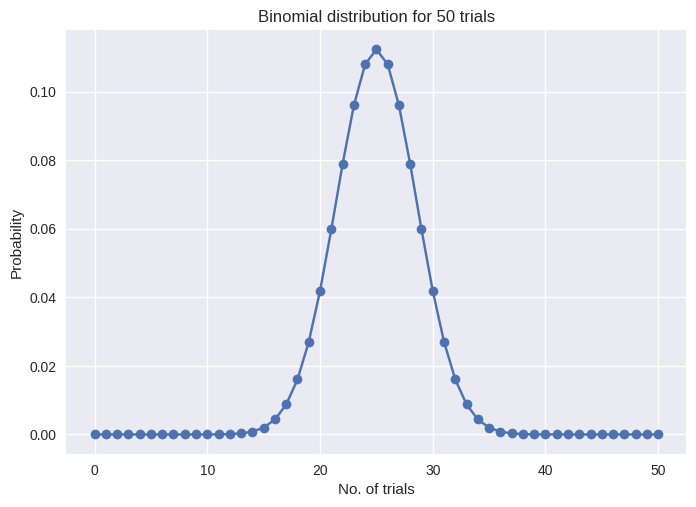

In [ ]:
# Calculate the probability mass function
TRIALS = 50
pmf = [sp.stats.binom.pmf(x, TRIALS, .5) for x in range(TRIALS + 1)]
def get_tail_items(pmf):
  total = 0
  for i, x in enumerate(pmf):
    total += x
    if total >= 0.05:
        break
  return i

# plot the binomial distribution
plt.plot([i for i in range(TRIALS + 1)], pmf,"-o")
plt.title(f"Binomial distribution for {TRIALS} trials")
plt.xlabel("No. of trials")
plt.ylabel("Probability")
plt.grid(True)

In [ ]:
# select features from n number of trials
def choose_features(feature_hits, TRIALS, thresh):
    #define boundries
    green_zone_thresh = TRIALS - thresh
    blue_zone_upper = green_zone_thresh
    blue_zone_lower = thresh
    green_zone = [key for key, value in feature_hits.items() if    value >= green_zone_thresh]
    blue_zone = [key for key, value in feature_hits.items() if (value >= blue_zone_lower and value < blue_zone_upper)]
    return green_zone, blue_zone

In [ ]:
#Afghanistan
afgh_train_X = Afghanistan_train_data.drop(['ID', 'shadow_ID', 'shadow_Country',  'Target', 'Country'], axis = 1).fillna(0)
afgn_train_Y = Afghanistan_train_data.Target

#Iran
Iran_train_X = Iran_train_data.drop(['ID', 'shadow_ID', 'Target'], axis = 1).fillna(0)
Iran_train_Y = Iran_train_data.Target

#Sudan
Sudan_train_X = Sudan_train_data.drop(['ID', 'shadow_ID', 'Target'], axis = 1).fillna(0)
Sudan_train_Y = Sudan_train_data.Target

In [ ]:
def compute_feature_hits(country_data, country_train_X, country_train_Y, TRIALS=50):
    feature_hits = {i: 0 for i in country_data.drop(['ID'], axis=1).fillna(0).columns}

    for _ in tqdm(range(TRIALS)):
        imp_features = get_important_features(country_train_X, country_train_Y)
        for key in feature_hits:
            if key in imp_features:
                feature_hits[key] += 1

    return feature_hits


thresh = get_tail_items(pmf)
countries = {
    'Afghanistan': (Afghanistan_train_data, afgh_train_X, afgn_train_Y),
    'Iran': (Iran_train_data, Iran_train_X, Iran_train_Y),
    'Sudan': (Sudan_train_data, Sudan_train_X, Sudan_train_Y)
}

results = {}
relevant_features = {}
for country, (country_data, country_train_X, country_train_Y) in countries.items():
    feature_hits = compute_feature_hits(country_data, country_train_X, country_train_Y)
    results[country] = feature_hits
    green, blue = choose_features(feature_hits, TRIALS, thresh)
    print(len(green), len(blue))
    relevant_features[country] = green + blue
    print(f'{country} Most Relevant Features: {feature_hits}')


  0%|          | 0/50 [00:00<?, ?it/s]

15 2
Afghanistan Most Relevant Features: {'Lat': 50, 'Lon': 50, 'Target': 0, 'Country': 0, 'B2': 50, 'B3': 34, 'B4': 47, 'B5': 26, 'B6': 1, 'B7': 19, 'B8': 33, 'B8A': 32, 'B11': 39, 'B12': 50, 'NDVI': 50, 'NDWI': 50, 'SAVI': 50, 'EVI': 50, 'NDRE': 50, 'CC': 50, 'shadow_ID': 0, 'shadow_Lat': 0, 'shadow_Lon': 0, 'shadow_Target': 0, 'shadow_Country': 0, 'shadow_B2': 0, 'shadow_B3': 0, 'shadow_B4': 0, 'shadow_B5': 0, 'shadow_B6': 0, 'shadow_B7': 0, 'shadow_B8': 0, 'shadow_B8A': 0, 'shadow_B11': 0, 'shadow_B12': 0, 'shadow_NDVI': 0, 'shadow_NDWI': 0, 'shadow_SAVI': 0, 'shadow_EVI': 0, 'shadow_NDRE': 0, 'shadow_CC': 0}


  0%|          | 0/50 [00:00<?, ?it/s]

84 20
Iran Most Relevant Features: {'Lat': 14, 'Lon': 39, 'Target': 0, 'B2_07_2019': 6, 'B3_07_2019': 2, 'B4_07_2019': 3, 'B5_07_2019': 6, 'B6_07_2019': 2, 'B7_07_2019': 0, 'B8_07_2019': 4, 'B8A_07_2019': 2, 'B11_07_2019': 2, 'B12_07_2019': 1, 'NDVI_07_2019': 26, 'NDWI_07_2019': 30, 'SAVI_07_2019': 37, 'EVI_07_2019': 40, 'NDRE_07_2019': 9, 'CC_07_2019': 17, 'B2_08_2019': 16, 'B3_08_2019': 10, 'B4_08_2019': 6, 'B5_08_2019': 9, 'B6_08_2019': 2, 'B7_08_2019': 0, 'B8_08_2019': 1, 'B8A_08_2019': 7, 'B11_08_2019': 13, 'B12_08_2019': 1, 'NDVI_08_2019': 3, 'NDWI_08_2019': 3, 'SAVI_08_2019': 0, 'EVI_08_2019': 2, 'NDRE_08_2019': 0, 'CC_08_2019': 2, 'B2_09_2019': 21, 'B3_09_2019': 19, 'B4_09_2019': 26, 'B5_09_2019': 29, 'B6_09_2019': 0, 'B7_09_2019': 0, 'B8_09_2019': 0, 'B8A_09_2019': 1, 'B11_09_2019': 35, 'B12_09_2019': 6, 'NDVI_09_2019': 31, 'NDWI_09_2019': 32, 'SAVI_09_2019': 40, 'EVI_09_2019': 36, 'NDRE_09_2019': 31, 'CC_09_2019': 40, 'B2_10_2019': 50, 'B3_10_2019': 38, 'B4_10_2019': 46, 'B5_

  0%|          | 0/50 [00:00<?, ?it/s]

132 31
Sudan Most Relevant Features: {'Lat': 48, 'Lon': 14, 'Target': 0, 'B2_07_2019': 23, 'B3_07_2019': 40, 'B4_07_2019': 44, 'B5_07_2019': 46, 'B6_07_2019': 50, 'B7_07_2019': 50, 'B8_07_2019': 50, 'B8A_07_2019': 49, 'B11_07_2019': 50, 'B12_07_2019': 49, 'NDVI_07_2019': 44, 'NDWI_07_2019': 44, 'SAVI_07_2019': 49, 'EVI_07_2019': 50, 'NDRE_07_2019': 38, 'CC_07_2019': 38, 'B2_08_2019': 0, 'B3_08_2019': 0, 'B4_08_2019': 0, 'B5_08_2019': 0, 'B6_08_2019': 0, 'B7_08_2019': 0, 'B8_08_2019': 0, 'B8A_08_2019': 0, 'B11_08_2019': 0, 'B12_08_2019': 0, 'NDVI_08_2019': 0, 'NDWI_08_2019': 0, 'SAVI_08_2019': 0, 'EVI_08_2019': 0, 'NDRE_08_2019': 0, 'CC_08_2019': 0, 'B2_09_2019': 36, 'B3_09_2019': 40, 'B4_09_2019': 36, 'B5_09_2019': 46, 'B6_09_2019': 29, 'B7_09_2019': 39, 'B8_09_2019': 42, 'B8A_09_2019': 45, 'B11_09_2019': 4, 'B12_09_2019': 26, 'NDVI_09_2019': 38, 'NDWI_09_2019': 24, 'SAVI_09_2019': 47, 'EVI_09_2019': 49, 'NDRE_09_2019': 47, 'CC_09_2019': 50, 'B2_10_2019': 47, 'B3_10_2019': 48, 'B4_10_2

## **Model Evaluation**

In this section, I checked how well the baseline classifers (RF, KNN, LDA, LR, QDA, CART, BAG, Ada, GBC, Lgbm, XGB) can learn from this dataset using 5 fold cross validation. This will help identify  the top-performing models and pinpointing those that may benefit from further refinement. This is done for each country separetly.


In [ ]:
def evaluate_models(train_data, models):
    """
    evaluate each model in turn (spot checking algorithms (of baselines))
    """

    print("{:<10} | {:<15} | {:<15}".format('Model', 'Accuracy (mean)', 'Accuracy (std)'))
    print("--------------------------------------------")

    train_X = train_data.drop(['ID', 'Target'], axis = 1).fillna(0)
    train_Y = train_data.Target
    acc, names = [], []

    for name, model in models:
      names.append(name)
      cv_results = cross_val_score(
          model,
          train_X,
          train_Y,
          cv=5,
          scoring='accuracy',
          n_jobs=-1,
          error_score='raise'
          )

      acc.append(cv_results)
      print("{:<10} | {:<15.3f} | {:<15.3f}".format(name, cv_results.mean(), cv_results.std()))
      print("--------------------------------------------")

In [ ]:
# Model selection
# Create a list of standard classifiers
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('LR', LogisticRegression(random_state=SEED, n_jobs=-1)))
models.append(('CART', DecisionTreeClassifier(random_state=SEED)))
models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
models.append(('Bag', BaggingClassifier(random_state=SEED, n_jobs=-1)))
models.append(('Ada', AdaBoostClassifier(random_state=SEED)))
models.append(('RF', RandomForestClassifier(n_jobs=-1,random_state=SEED)))
models.append(('GBC', GradientBoostingClassifier(random_state=SEED)))
models.append(('Lgbm', LGBMClassifier(random_state=SEED, objective='binary', metric='binary_logloss')))
models.append(('XGB', XGBClassifier(n_jobs=-1, random_state=SEED, objective='binary:logistic', eval_metric='logloss')))

**Compare baseline models**

In [ ]:
stable_cols_Afgh = ['ID','Target']
stable_cols_Sudan = ['ID','Lon', 'Target',]
stable_cols_Iran = ['ID', 'Lat', 'Target']

In [ ]:
Afghanistan_train_data = Afghanistan_train_data[relevant_features['Afghanistan'] + stable_cols_Afgh]
Iran_train_data = Iran_train_data[relevant_features['Iran'] + stable_cols_Iran]
Sudan_train_data = Sudan_train_data[relevant_features['Sudan'] + stable_cols_Sudan]

In [ ]:
#evaluate the models using the Afghanistan train data
evaluate_models(Afghanistan_train_data, models)

Model      | Accuracy (mean) | Accuracy (std) 
--------------------------------------------
LDA        | 0.810           | 0.021          
--------------------------------------------
QDA        | 0.804           | 0.048          
--------------------------------------------
LR         | 0.762           | 0.031          
--------------------------------------------
CART       | 0.762           | 0.012          
--------------------------------------------
KNN        | 0.800           | 0.018          
--------------------------------------------
Bag        | 0.808           | 0.026          
--------------------------------------------
Ada        | 0.798           | 0.032          
--------------------------------------------
RF         | 0.810           | 0.023          
--------------------------------------------
GBC        | 0.842           | 0.023          
--------------------------------------------
Lgbm       | 0.834           | 0.029          
---------------------------------

In [ ]:
#evaluate the models using the Sudan train data
evaluate_models(Sudan_train_data, models)

Model      | Accuracy (mean) | Accuracy (std) 
--------------------------------------------
LDA        | 0.970           | 0.014          
--------------------------------------------
QDA        | 0.976           | 0.005          
--------------------------------------------
LR         | 0.942           | 0.013          
--------------------------------------------
CART       | 0.938           | 0.022          
--------------------------------------------
KNN        | 0.980           | 0.011          
--------------------------------------------
Bag        | 0.972           | 0.016          
--------------------------------------------
Ada        | 0.968           | 0.013          
--------------------------------------------
RF         | 0.978           | 0.010          
--------------------------------------------
GBC        | 0.972           | 0.012          
--------------------------------------------
Lgbm       | 0.976           | 0.010          
---------------------------------

In [ ]:
#evaluate the models using the Iran train data
evaluate_models(Iran_train_data, models)

Model      | Accuracy (mean) | Accuracy (std) 
--------------------------------------------
LDA        | 0.936           | 0.019          
--------------------------------------------
QDA        | 0.944           | 0.022          
--------------------------------------------
LR         | 0.934           | 0.033          
--------------------------------------------
CART       | 0.902           | 0.034          
--------------------------------------------
KNN        | 0.944           | 0.028          
--------------------------------------------
Bag        | 0.932           | 0.033          
--------------------------------------------
Ada        | 0.938           | 0.032          
--------------------------------------------
RF         | 0.956           | 0.024          
--------------------------------------------
GBC        | 0.940           | 0.028          
--------------------------------------------
Lgbm       | 0.954           | 0.027          
---------------------------------

**Hyperparameter Tuning**

Based on the preceding results, it is evident that XGBoost consistently outperforms the other models across all three countries.

In this section, I will focus on tuning XGBoost hyperparameters exclusively using the training data and cross-validation techniques for each country separetly.

Hyperparameter tuning is done here uing Optuna. Optuna offers a more sophisticated approach to hyperparameter tuning compared to traditional methods like grid search or random search. Grid search systematically tries every possible combination of parameters, which can be computationally expensive and time-consuming, especially when the hyperparameter space is vast. Random search, on the other hand, selects random combinations of parameters but offers no guarantee of finding the optimal set within a given number of trials. Optuna, however, employs a Bayesian optimization-based strategy, which uses the information from previous trials to suggest more promising parameter combinations. This "intelligent" sampling leads to more efficient searches, often requiring fewer trials to find optimal or near-optimal hyperparameters.

In [ ]:
def create_knn(trial):
    return KNeighborsClassifier(
        n_neighbors=trial.suggest_int("n_neighbors", 2, 50),
        n_jobs=-1)


def create_qda(trial):
    return QuadraticDiscriminantAnalysis(
        reg_param=trial.suggest_float("reg_param", 0.0, 1.0)
        )



def create_bag(trial):
    return BaggingClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 2000),
        random_state=SEED,
        n_jobs=-1
        )


def create_gbc(trial):
    return GradientBoostingClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 2000),
        max_depth=trial.suggest_int("max_depth", 5, 40, log=True),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        random_state=SEED
        )

def create_rf(trial):
    return RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 3000),
        max_depth=trial.suggest_int("max_depth", 5, 40, log=True),
        criterion=trial.suggest_categorical("criterion", ["gini", "entropy"]),
        min_samples_split=trial.suggest_float("min_samples_split", 0.1, 1.0),
        min_samples_leaf=trial.suggest_float("min_samples_leaf", 0.1, 0.5),
        max_features=trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
        random_state=SEED
    )

def create_lgbm(trial):
    return LGBMClassifier(
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 50, 2000),
        boosting_type=trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        max_depth=trial.suggest_int("max_depth", 5, 40, log=True),
        num_leaves=trial.suggest_int("num_leaves", 2, 500),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 300),
        feature_fraction=trial.suggest_float("feature_fraction", 0.1, 1.0),
        bagging_fraction=trial.suggest_float("bagging_fraction", 0.1, 1.0),
        bagging_freq=trial.suggest_int("bagging_freq", 1, 7),
        objective='binary',
        metric='binary_logloss',
        random_state=SEED
    )

def create_xgb(trial):
    return XGBClassifier(
        learning_rate=trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 50, 3000),
        max_depth=trial.suggest_int("max_depth", 5, 50, log=True),
        subsample=trial.suggest_float("subsample", 0.1, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.1, 1.0),
        n_jobs=-1,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=SEED
    )



def objective(train_data, model_type, trial):
    model = MODEL_FUNCS[model_type](trial)

    train_X = train_data.drop(['ID', 'Target'], axis = 1).fillna(0)
    train_Y = train_data.Target

    # Use cross_val_predict to get predicted probabilities for each fold
    cv_results = cross_val_score(
        model,
        train_X,
        train_Y,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        error_score='raise'
          )

    return cv_results.mean()


# Optuna Optimization
MODEL_FUNCS = {
    'gbc': create_gbc,
    'bag': create_bag,
    'knn': create_knn,
    'qda': create_qda,
    'rf': create_rf,
    'lgbm': create_lgbm,
    'xgb': create_xgb
}


# Objective Function for Optuna
def run_optimization(model_type, train_data, n_trials=100):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(train_data, model_type, trial), n_trials=n_trials)
    print(f"{model_type.upper()} best parameters: ", study.best_params)

In [ ]:
run_optimization('xgb', Afghanistan_train_data, 500)

[I 2023-09-21 14:10:37,945] A new study created in memory with name: no-name-5aa03491-c853-497d-858a-3798be2993a9
[I 2023-09-21 14:10:39,294] Trial 0 finished with value: 0.79 and parameters: {'learning_rate': 1.879666980054014e-05, 'n_estimators': 456, 'max_depth': 40, 'subsample': 0.41926320060567424, 'colsample_bytree': 0.4662464220803345}. Best is trial 0 with value: 0.79.
[I 2023-09-21 14:10:42,916] Trial 1 finished with value: 0.8300000000000001 and parameters: {'learning_rate': 0.028393325376357102, 'n_estimators': 730, 'max_depth': 11, 'subsample': 0.7376572722585373, 'colsample_bytree': 0.7620098814045577}. Best is trial 1 with value: 0.8300000000000001.
[I 2023-09-21 14:10:49,766] Trial 2 finished with value: 0.8379999999999999 and parameters: {'learning_rate': 0.012999348057472127, 'n_estimators': 1238, 'max_depth': 8, 'subsample': 0.4425803628749465, 'colsample_bytree': 0.7223469448795189}. Best is trial 2 with value: 0.8379999999999999.
[I 2023-09-21 14:10:59,568] Trial 3 

XGB best parameters:  {'learning_rate': 0.0052493969604778335, 'n_estimators': 2063, 'max_depth': 17, 'subsample': 0.4686499286014045, 'colsample_bytree': 0.7475032992018813}


In [ ]:
run_optimization('xgb', Iran_train_data, 500)

[I 2023-09-21 15:18:49,683] A new study created in memory with name: no-name-66199ba4-22d5-4318-963a-e101303d3797
[I 2023-09-21 15:19:25,318] Trial 0 finished with value: 0.938 and parameters: {'learning_rate': 5.892402514188225e-05, 'n_estimators': 2992, 'max_depth': 31, 'subsample': 0.3722323052831178, 'colsample_bytree': 0.5751058942959152}. Best is trial 0 with value: 0.938.
[I 2023-09-21 15:20:18,699] Trial 1 finished with value: 0.942 and parameters: {'learning_rate': 0.00015006991755663925, 'n_estimators': 2452, 'max_depth': 14, 'subsample': 0.8350158549603934, 'colsample_bytree': 0.46549025105601083}. Best is trial 1 with value: 0.942.
[I 2023-09-21 15:20:22,857] Trial 2 finished with value: 0.942 and parameters: {'learning_rate': 0.0002023283640316383, 'n_estimators': 96, 'max_depth': 16, 'subsample': 0.8765828014113869, 'colsample_bytree': 0.7166071816337113}. Best is trial 1 with value: 0.942.
[I 2023-09-21 15:20:36,685] Trial 3 finished with value: 0.9400000000000001 and pa

XGB best parameters:  {'learning_rate': 0.04074652544112853, 'n_estimators': 454, 'max_depth': 8, 'subsample': 0.3153099125619524, 'colsample_bytree': 0.1593272485470127}


In [ ]:
run_optimization('xgb', Sudan_train_data, 500)

[I 2023-09-21 17:15:43,167] A new study created in memory with name: no-name-82ac1f8f-f9c5-4711-a05f-9441d3842fbf
[I 2023-09-21 17:18:02,068] Trial 0 finished with value: 0.954 and parameters: {'learning_rate': 9.096453170325128e-05, 'n_estimators': 2275, 'max_depth': 9, 'subsample': 0.985637059432807, 'colsample_bytree': 0.8529797413035486}. Best is trial 0 with value: 0.954.
[I 2023-09-21 17:18:30,842] Trial 1 finished with value: 0.922 and parameters: {'learning_rate': 0.0001437112485585751, 'n_estimators': 2524, 'max_depth': 44, 'subsample': 0.17784845249232692, 'colsample_bytree': 0.7559449110449329}. Best is trial 0 with value: 0.954.
[I 2023-09-21 17:18:53,691] Trial 2 finished with value: 0.958 and parameters: {'learning_rate': 0.00029020227713015225, 'n_estimators': 592, 'max_depth': 10, 'subsample': 0.7052607998187295, 'colsample_bytree': 0.655008027729967}. Best is trial 2 with value: 0.958.
[I 2023-09-21 17:18:59,247] Trial 3 finished with value: 0.9200000000000002 and para

XGB best parameters:  {'learning_rate': 0.03715547309484834, 'n_estimators': 2529, 'max_depth': 7, 'subsample': 0.8646850677612571, 'colsample_bytree': 0.1453916995501207}


**XGBoost Model Training**

In this section, we establish a dedicated model for each country, leveraging the optimized hyperparameters obtained earlier through Optuna. These tuned models are subsequently harnessed to produce predictions for each respective country based on the test dataframes and the selected features (check previous sections).

In [ ]:
afgh_xgb = XGBClassifier(
        learning_rate=0.0052493969604778335,
        n_estimators=2063,
        max_depth=17,
        subsample=0.4686499286014045,
        colsample_bytree=0.7475032992018813,
        n_jobs=-1,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=SEED
    )

afgh_train_X = Afghanistan_train_data.drop(['ID', 'Target'], axis = 1).fillna(0)
afgn_train_Y = Afghanistan_train_data.Target

afgh_xgb.fit(afgh_train_X, afgn_train_Y)

# Make predictions
Afghanistan_test_data = Afghanistan_test_data [relevant_features['Afghanistan'] + stable_cols_Afgh[:1]]
afgh_test_X = Afghanistan_test_data.drop(['ID'], axis = 1).fillna(0)
afgh_predictions = afgh_xgb.predict(afgh_test_X)

In [ ]:
Iran_xgb = XGBClassifier(
        learning_rate=0.04074652544112853,
        n_estimators=454,
        max_depth=8,
        subsample=0.3153099125619524,
        colsample_bytree=0.1593272485470127,
        n_jobs=-1,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=SEED
    )

Iran_train_X = Iran_train_data.drop(['ID', 'Target'], axis = 1).fillna(0)
Iran_train_Y = Iran_train_data.Target

Iran_xgb.fit(Iran_train_X, Iran_train_Y)

# Make predictions
Iran_test_X = Iran_test_data [relevant_features['Iran'] + stable_cols_Iran[:2]]
Iran_predictions = Iran_xgb.predict(Iran_test_X.drop(['ID'], axis = 1).fillna(0))

In [ ]:
Sudan_xgb = XGBClassifier(
        learning_rate=0.03715547309484834,
        n_estimators=2529,
        max_depth=7,
        subsample=0.8646850677612571,
        colsample_bytree=0.1453916995501207,
        n_jobs=-1,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=SEED
    )

Sudan_train_X = Sudan_train_data.drop(['ID', 'Target'], axis = 1).fillna(0)
Sudan_train_Y = Sudan_train_data.Target

Sudan_xgb.fit(Sudan_train_X, Sudan_train_Y)

# Make predictions
Sudan_test_X = Sudan_test_data [relevant_features['Sudan'] + stable_cols_Sudan[:2]]
Sudan_predictions = Sudan_xgb.predict(Sudan_test_X.drop(['ID'], axis = 1).fillna(0))

The three prediction dataframes (for each country) are merged into one submission file.

In [ ]:
# Create a submission file
Afgh_predictions_df = pd.DataFrame({'ID': Afghanistan_test_data.ID, 'Target': afgh_predictions})
Sudan_predictions_df = pd.DataFrame({'ID': Sudan_test_data.ID, 'Target': Sudan_predictions})
Iran_predictions_df = pd.DataFrame({'ID': Iran_test_data.ID, 'Target': Iran_predictions})

submission_file = pd.concat([Afgh_predictions_df,
                             Sudan_predictions_df,
                             Iran_predictions_df
                             ], axis=0)

submission_file.to_csv('XGB_submission.csv', index = False)